## Import the necessary software libraries:

In [ ]:
!pip install gym==0.15.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.15.3-py3-none-any.whl size=1644968 sha256=fe6a73efab76ad80a4f0e52b8ed824824176d38c876b5c939601e8b00fdd5b6b
  Stored in directory: /root/.cache/pip/wheels/9b/b4/52/f4cce4bdc360a2289a3433deaa062ceb13dbe429c342866e97
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [8]:
import random
import copy
import gym
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
from gym import wrappers, Env, spaces
# from utils import test_agent, plot_stats, seed_everything

## Create and prepare the environment

### Create the environment

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [10]:
# class Single_Agent_UAV(Env):
#     def __init__(self, initial_UAV_state = None):
#         super(Single_Agent_UAV, self).__init__()

#         #self.initial_UAV_state = initial_UAV_state
#         self.initial_UAV_state = np.array([50,50])
#         self.UE_count = 30
#         self.Z = 20
#         self.horizontal_dist_max = 20
#         self.max_angle = 2 * math.pi
#         # self.dz_max = 20
#         self.phi_n = np.radians(42.44)  # in degrees
#         self.C_max_t = (self.Z / np.tan(self.phi_n))
#         self.boundary_x = self.boundary_y = 100.
#         self.max_episode_steps = 20 # Maximum number of steps in a single episode, after which environment returns done = True
#         self.current_episode_timestep = 0
#         self.done = False
#         self.action_step_size = self.boundary_x / 25.

#         # self.action_space_coversion_lb = np.array([0, 0])
#         # self.action_space_coversion_ub = np.array([self.horizontal_dist_max, self.max_angle])

#         # self.action_space_lb = -1 * np.ones(2)
#         # self.action_space_ub = np.ones(2)
#         self.state_space_lb = np.array([0 for i in range(self.UE_count + 2)])
#         self.state_space_ub = [self.boundary_x, self.boundary_y]
#         for i in range(self.UE_count):
#             self.state_space_ub.append(1)
#         self.state_space_ub = np.array(self.state_space_ub)
        
#         # plotting parameters
#         self.plotting_boundary_buffer = 5.
#         self.UAV_coverage_circle_color = 'lavender'
#         self.EC_concentrated_region_color = 'mistyrose'
#         self.UAV_path_color = 'green'


# #         defining action space
#         self.state_space = gym.spaces.box.Box(low = self.state_space_lb, high = self.state_space_ub)
# #         defining observation space
#         self.action_space = spaces.Discrete(9)

#         self.place_UEs(position="centered", center = None)
#         self.action_conversion()


#     def action_conversion(self):
#         self.n_actions = self.action_space.n
#         # HARDCODED FOR n=9
#         diag = (1 / math.sqrt(2))
#         self.index_to_action_mapper = [(0, 0 ), (1, 0), (diag, diag), (0, 1), (-diag, diag), (-1, 0), (-diag, -diag), (0, -1), (diag, -diag)]  # angle changes in clockwise fashion
#         return


#     def reset(self):
#         self.current_state = np.array(self.initial_UAV_state)
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state[:2], axis = 1)
#         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
#         self.current_state = np.concatenate((self.current_state[:2], rho_array))
#         self.timesteps_in_episode = 0
#         self.done = False
#         return self.current_state
    
    
#     def get_count_of_UEs_covered(self):
#         '''
#         Returns count of UEs covered under UAV's current configuration
#         '''

#         ground_UAV_state = self.current_state[:2]
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         # print("horizontal distance b/w UEs and UAV: ", horizontal_dist_UE_UAV)
#         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
#         M_t = rho_array.sum()

#         return M_t


#     def render(self, **kwargs):
#         '''
#         Function to visualize UAV position
#         (this function has different configurations for different use cases)
#         '''

#         if 'UAV_positions_list' in kwargs:
#             self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

#         if 'fig' not in kwargs:
#             fig, ax = plt.subplots(1, 2, figsize=(20,10))
#             ax = np.array([ax])
#             kwargs['fig'] = fig
#             kwargs['ax'] = ax
#             kwargs['i'] = 0
        
#         if 'reward' not in kwargs:
#             kwargs['reward'] = 'Not known'
#         self.render_position_plot(**kwargs)


#     def step(self, action):
#         '''
#         Takes action moving environment from current_state to next_state
#         Arguments: `action` to be taken
#         Returns: new_state, reward, done, info(=None)
#         '''
#         # action = action.numpy().flatten()
#         err_msg = f"{action!r} ({type(action)}) invalid"
#         assert self.action_space.contains(action), err_msg
#         assert self.current_state is not None, "Call reset before using step method."


#         self.timesteps_in_episode += 1
#         prev_UAV_state = self.current_state
#         _, inside_bounds = self.move(action)
#         # print(type(self.current_state), type(prev_UAV_state))
#         if not inside_bounds:
#             # MENTIONED OUTPUT IS OUT OF BOUNDS
#             self.is_done(end = True)
#             reward = -500
#             return self.current_state, reward, self.done, None

#         ground_UAV_state = self.current_state[:2]
#         horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - ground_UAV_state, axis = 1)
#         rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
#         self.current_state = np.concatenate((self.current_state[:2], rho_array))
#         M_t = rho_array.sum()  # no. of UEs served by the agent

#         reward = M_t * 10         
#         self.is_done(M_t)
        
#         return self.current_state, reward, self.done, None
    

#     def move(self, action):
#         '''
#         Helper function to step() function.
#         Clips the passed action to fit within action space bounds.
#         Calculates new state after performing the passed action, and updates UAV position accordingly. 
#         '''
# #         evaluates new state reached upon performing the move and saves it in self.current_state
#         # ACTION = [dx, dy]
#         x_next = self.current_state[0] + (self.index_to_action_mapper[action][0] * self.action_step_size)
#         y_next = self.current_state[1] + (self.index_to_action_mapper[action][1] * self.action_step_size)
        
#     # updating horizontal_direction_angle if the new move is out of boundary
#         if((x_next < 0) or (x_next > self.boundary_x) or (y_next < 0) or (y_next > self.boundary_y)):
#             # UAV REMAINS IN ITS CURRENT POSITION
#             return action, False

#         self.current_state[:2] = np.array([x_next, y_next])
#         return action, True


#     def is_done(self, M_t=0, end=False):
#         '''
#         Helper function to check if episode needs to be terminated
#         '''
#         if end == True:
#             self.done = True
#         # if M_t >= int(0.6 * self.UE_count):
#         #     self.done = True
#         elif(self.timesteps_in_episode >= self.max_episode_steps):
#             self.done = True
#         return

    
#     def select_random_state(self):
#         '''
#         Selects (and returns) random initial state (within bounds) for the UAV
#         '''
#         new_x = np.random.uniform(0.0, self.boundary_x)
#         new_y = np.random.uniform(0.0, self.boundary_y)
#         return np.array([new_x, new_y])
    

#     def place_UEs_centered(self, center = None, centered_UE_count = None):
#         '''
#         Helper function to place_UEs
#         Places `centered_UE_count` UEs within a circle with center `center` and radius `C_max_t`.
#         Places remaining UEs (UE_count - centered_UE_count) randomly inside the area barring the above circular region
#         Arguments: 
#             desired_z_coord: Z coordinate with which to calculate radius C_max_t for centering UEs
#             center: Provides center of circular region in which UEs will be scattered
#             centered_UE_count: Number of UEs to be placed within the circular region created using previous arguments
#         '''

#         if centered_UE_count is None:
#           centered_UE_count = self.UE_count
#         # focuses the UEs inside the circular region
#         radius = self.C_max_t
#         if(center == None):
#             # (x, y) co-ordinates
#             x = np.random.uniform(0, self.boundary_x)
#             y = np.random.uniform(0, self.boundary_y)
#             center = np.array([x, y])

#         r = radius * np.sqrt(np.random.uniform(size = centered_UE_count))
#         theta = np.random.uniform(size = centered_UE_count) * 2 * math.pi

#         self.UE_center = center
#         self.UE_radius = radius
        

#         self.UE_positions = np.zeros((centered_UE_count, 2))
#         self.UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
#         self.UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
#         return


#     def place_UEs_randomly(self, random_UE_count = None, **kwargs):
#         '''
#         Helper function to place_UEs
#         places `random_UE_count` UEs randomly onto the rectangular region
#         if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
#         and `exclude_radius` is excluded

#         '''

#         if random_UE_count is None:
#           random_UE_count = self.UE_count

#         # places UE_count UEs on grid randomly
#         if type(self.UE_positions) == np.ndarray:
#             self.UE_positions = self.UE_positions.tolist()

#         randomly_placed_count = 0
#         while(randomly_placed_count < random_UE_count):
#             x = np.random.uniform(0, self.boundary_x)
#             y = np.random.uniform(0, self.boundary_y)
#             coords = np.array([x, y])
#             if 'exclude_center' in kwargs:
#                 if (np.linalg.norm(coords - kwargs['exclude_center']) <= kwargs['exclude_radius']):
#                     continue
#             self.UE_positions.append(coords)
#             randomly_placed_count += 1

#         self.UE_positions = np.array(self.UE_positions)


#     def place_UEs(self, position="random", center = None):
#         '''
#         Function to place UEs onto the rectangular region
#         Arguments:
#             position: has 2 modes, "random" and "centered", representing the two configuration for scattering UEs
#             desired_z_coord: if position="centered", this argument gives height with which to calculate radius of circular region
#             center: if position="centered", this argument provides center of circular region
#         '''

#         self.UE_center = None  # initializing for non-centered generation algorithms

#         if(position=="centered"):
#             ratio = 0.65
#             centered_count = int(ratio * self.UE_count)
#             self.place_UEs_centered(center, centered_count)
#             if(self.UE_count - centered_count > 0):
#                 self.place_UEs_randomly(self.UE_count - centered_count, exclude_center = self.UE_center, exclude_radius = self.UE_radius)
#         elif(position=="random"):
#             self.place_UEs_randomly()

#         # saves in self.UE_positions
#         self.UE_positions = np.array(self.UE_positions)
#         return


#     def render_policy_plot(self, **kwargs):

#         fig, ax = plt.subplots(1, figsize=(10,10))
#         position_action_list = kwargs['position_action_list']
#         for position_action in position_action_list:
#             position = position_action[0]
#             action = position_action[1]
#             new_state = self.move(action, get_new_state=True)
#             ax.arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.09, head_length=0.1)
#         plt.show()
#         return


#     def render_bar_plot(self, ax, plot_number, idx):
#         '''
#         Plotting bar graph of each UE's fraction of tasks assigned to UAV and to EC, by the last action input given to step() function
#         '''
#         x_indices = np.arange(self.UE_count)
#         width = 0.5

#         gamma_array = (np.array(self.last_action[4:])).reshape((self.UE_count, self.EC_count))
#         gamma_zeros = (1 - gamma_array.sum(axis = 1))
        
#         ax[plot_number, idx].bar(x_indices, gamma_zeros, width=width)
#         for i in range(self.EC_count):
#             ax[plot_number, idx].bar(x_indices, gamma_array[:, i], width=width)
        
    
#     def render_position_plot(self, **kwargs):
#         '''
#         Helper function to render(), plots the current position plot on given axes. 
#         Plotting position plot of UAV's current position and coverage
#         '''
#         ax = kwargs['ax']
#         plot_number = kwargs['i']
#         idx = 0
#         reward = kwargs['reward']

#         buffer = 5.
#         ax[plot_number, idx].set_xlim(-buffer, self.boundary_x+buffer)
#         ax[plot_number, idx].set_ylim(-buffer, self.boundary_y+buffer)
#         ax[plot_number, idx].grid()
#         UE_x = self.UE_positions[:, 0]
#         UE_y = self.UE_positions[:, 1]
#         ax[plot_number, idx].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
#         ax[plot_number, idx].plot(self.current_state[0], self.current_state[1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
        
#         UAV_coverage_area = plt.Circle((self.current_state[0] , self.current_state[1] ), self.C_max_t, color = self.UAV_coverage_circle_color)
#         ax[plot_number, idx].add_artist(UAV_coverage_area)
      
#       # For testing: To plot the circle and visualize UE points inside it
#         if self.UE_center is not None:
#             Test_UE_allotment_circle = plt.Circle((self.UE_center[0] , self.UE_center[1]), self.UE_radius, color = self.EC_concentrated_region_color)
#             ax[plot_number, idx].add_artist(Test_UE_allotment_circle)
#       # End

#         if 'learnt_policy_visualization' in kwargs:
#             position_action_list = kwargs['position_action_list']
#             for position_action in position_action_list:
#                 position = position_action[0]
#                 action = position_action[1]
#                 action = np.clip(action, self.action_space_lb, self.action_space_ub)
#                 action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
#                 print("scaled action: ", action)
#                 # print("action after scaling: ", action)
#                 new_state = self.move(action, get_new_state=True, provided_center=position)
#                 print("previous state: ", position, ", new state: ", new_state)
#                 # print("new_state: ", new_state)
#                 ax[plot_number, idx].plot(position[0], position[1], color='blue', marker='o', markersize=6, linestyle = '')
#                 ax[plot_number, idx].plot(new_state[0], new_state[1], color='orange', marker='o', markersize=6, linestyle = '')
#                 ax[plot_number, idx].arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.2, head_length=0.1)


#         ax[plot_number, idx].set_aspect(1)
#         # naming the x axis
#         ax[plot_number, idx].set_xlabel('X pos (m)')
#         # naming the y axis
#         ax[plot_number, idx].set_ylabel('Y pos (m)')
#         ax[plot_number, idx].set_title('reward: ' + str(reward))
#         # giving a title to my graph
#         # plt.title('Visually Appealing!')

#         # show a legend on the plot
#         ax[plot_number, idx].legend()
#         # plt.show()

In [175]:
class Single_Agent_UAV(Env):
    def __init__(self, initial_UAV_state = None):
        super(Single_Agent_UAV, self).__init__()

        self.UAV_count = 1
        #self.initial_UAV_state = initial_UAV_state
        self.UE_count = 200
        self.Z = 20
        self.horizontal_dist_max = 20
        self.max_angle = 2 * math.pi
        # self.dz_max = 20
        self.phi_n = np.radians(42.44)  # in degrees
        self.C_max_t = (self.Z / np.tan(self.phi_n))
        # self.D_min = (2 * C_max_t) + self.boundary_x / 25.
        self.C_max_t_array = np.array([self.C_max_t for _ in range(self.UAV_count)])
        self.boundary_x = self.boundary_y = 150.
        self.max_episode_steps = 50 # Maximum number of steps in a single episode, after which environment returns done = True
        self.current_episode_timestep = 0
        self.done = False
        self.action_step_size = self.boundary_x / 25.
        self.initial_UAV_state = self.select_random_state()
        self.current_state = copy.deepcopy(self.initial_UAV_state)

        # self.action_space_coversion_lb = np.array([0, 0])
        # self.action_space_coversion_ub = np.array([self.horizontal_dist_max, self.max_angle])

        # self.action_space_lb = -1 * np.ones(2)
        # self.action_space_ub = np.ones(2)
        self.state_space_lb = np.array([0, 0], dtype = np.float32)
        self.state_space_ub = np.array([self.boundary_x, self.boundary_y], dtype = np.float32)
        
        # plotting parameters
        self.plotting_boundary_buffer = 5.
        self.UAV_coverage_circle_color = 'lavender'
        self.EC_concentrated_region_color = 'mistyrose'
        self.UAV_path_color = 'green'


#         defining action space
        self.state_space = np.array([gym.spaces.box.Box(low = self.state_space_lb, high = self.state_space_ub) for i in range(self.UAV_count)])
#         defining observation space
        self.action_space = np.array([spaces.Discrete(9) for i in range(self.UAV_count)])

        self.place_UEs(position="centered", center = None)
        self.action_conversion()


    def action_conversion(self):
        self.n_actions = self.action_space[0].n
        # HARDCODED FOR n=9
        diag = (1 / math.sqrt(2))
        self.index_to_action_mapper = [(0, 0 ), (1, 0), (diag, diag), (0, 1), (-diag, diag), (-1, 0), (-diag, -diag), (0, -1), (diag, -diag)]  # angle changes in clockwise fashion
        return


    def reset(self):
        # RANDOMLY SELECTS UAV STARTING POSITION
        self.current_state = self.select_random_state()
        
        # RESETS UAV STARTING POSITION TO self.initial_UAV_state
        # self.current_state = copy.deepcopy(self.initial_UAV_state)

        # FOLLOWING 3 LINES ARE USED IF THE STATE SPACE INVOLVES THE UE COVERED BINARY VECTOR
        # horizontal_dist_UE_UAV = np.linalg.norm(self.UE_positions - self.current_state[:2], axis = 1)
        # rho_array = (horizontal_dist_UE_UAV <= (self.C_max_t)) * 1  # binary association vector
        # self.current_state = np.concatenate((self.current_state[:2], rho_array))
        self.timesteps_in_episode = 0
        self.done = False
        return self.current_state
    
    
    def get_count_of_UEs_covered(self):
        '''
        Returns count of UEs covered under UAV's current configuration
        '''
        ground_UAV_state = self.current_state[:, :2]
        horizontal_dist_UE_UAV = np.array([np.linalg.norm(self.UE_positions - ground_UAV_state[i], axis = 1) for i in range(self.UAV_count)])
        rho_matrix = (horizontal_dist_UE_UAV <= (self.C_max_t_array[:, None])) * 1  # binary association vector [(n_uav x n_ue) dimensions]
        Mn_t = ((rho_matrix.sum(axis = 0) >= 1) * 1) 
        M_t = Mn_t.sum()  # total no. of UEs served by all the agent collectively
        return M_t


    def render(self, **kwargs):
        '''
        Function to visualize UAV position
        (this function has different configurations for different use cases)
        '''

        if 'UAV_positions_list' in kwargs:
            self.render_UAV_movement_through_episode(UAV_positions_list = kwargs['UAV_positions_list'])

        if 'fig' not in kwargs:
            fig, ax = plt.subplots(1, 2, figsize=(20,10))
            ax = np.array([ax])
            kwargs['fig'] = fig
            kwargs['ax'] = ax
            kwargs['i'] = 0
        
        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        self.render_position_plot(**kwargs)


    def step(self, action):
        '''
        Takes action moving environment from current_state to next_state
        Arguments: `action` to be taken
        Returns: new_state, reward, done, info(=None)
        '''
        # action = action.numpy().flatten()
        # print("action inside step: ", action)
        for i in range(self.UAV_count):
            err_msg = f"{action[i]!r} ({type(action[i])}) for UAV {i} invalid"
            assert self.action_space[i].contains(action[i]), err_msg
        assert self.current_state is not None, "Call reset before using step method."

        self.timesteps_in_episode += 1
        prev_UAV_state = copy.deepcopy(self.current_state)
        _, inside_bounds = self.move(action)
        # print(type(self.current_state), type(prev_UAV_state))
        if inside_bounds != 0:
            # MENTIONED OUTPUT IS OUT OF BOUNDS

            # self.is_done(end = True)
            reward = -100
            return self.current_state, reward, self.done, None

        ground_UAV_state = self.current_state[:, :2]
        horizontal_dist_UE_UAV = np.array([np.linalg.norm(self.UE_positions - ground_UAV_state[i], axis = 1) for i in range(self.UAV_count)])
        rho_matrix = (horizontal_dist_UE_UAV <= (self.C_max_t_array[:, None])) * 1  # binary association vector [(n_uav x n_ue) dimensions]
        Mn_t = ((rho_matrix.sum(axis = 0) >= 1) * 1) 
        M_t = Mn_t.sum()  # total no. of UEs served by all the agent collectively

        reward = M_t * 10         
        self.is_done(M_t)

        return self.current_state, reward, self.done, None
    

    def move(self, action):
        '''
        Helper function to step() function.
        Clips the passed action to fit within action space bounds.
        Calculates new state after performing the passed action, and updates UAV position accordingly. 
        '''
#         evaluates new state reached upon performing the move and saves it in self.current_state
        # ACTION = [dx, dy]
        x_next_array = np.array([(self.current_state[i][0] + (self.index_to_action_mapper[action[i]][0] * self.action_step_size)) for i in range(self.UAV_count)], dtype=np.float32)
        y_next_array = np.array([(self.current_state[i][1] + (self.index_to_action_mapper[action[i]][1] * self.action_step_size)) for i in range(self.UAV_count)], dtype=np.float32)
        
    # updating horizontal_direction_angle if the new move is out of boundary
        positive_reward = True
        if ((x_next_array < 0).any()) or ((y_next_array < 0).any()) or ((x_next_array > self.boundary_x).any()) or ((y_next_array > self.boundary_y).any()):
            # UAV REMAINS IN ITS CURRENT POSITION
            positive_reward = False

        x_next_array = np.clip(x_next_array, a_min=np.array([0 for i in range(self.UAV_count)]), a_max=np.array([self.boundary_x for i in range(self.UAV_count)]))
        y_next_array = np.clip(y_next_array, a_min=np.array([0 for i in range(self.UAV_count)]), a_max=np.array([self.boundary_y for i in range(self.UAV_count)]))
        self.current_state[:, :2] = np.array([[x_next_array[i], y_next_array[i]] for i in range(self.UAV_count)])
        return action, positive_reward


    def is_done(self, M_t=0, end=False):
        '''
        Helper function to check if episode needs to be terminated
        '''
        if end == True:
            self.done = True
        # if M_t >= int(0.6 * self.UE_count):
        #     self.done = True
        elif(self.timesteps_in_episode >= self.max_episode_steps):
            # print("setting done to True")
            self.done = True
        return

    
    def select_random_state(self):
        '''
        Selects (and returns) random initial state (within bounds) for the UAV
        '''
        UAV_pos_list = []
        for _ in range(self.UAV_count):
            new_x = np.random.uniform(0.0, self.boundary_x)
            new_y = np.random.uniform(0.0, self.boundary_y)
            UAV_pos_list.append(np.array([new_x, new_y]))

        return np.array(UAV_pos_list)


    def place_UEs_centered(self, center = None, centered_UE_count = None, radius = None):
        '''
        Helper function to place_UEs
        Places `centered_UE_count` UEs within a circle with center `center` and radius `C_max_t`.
        Places remaining UEs (UE_count - centered_UE_count) randomly inside the area barring the above circular region
        Arguments: 
            desired_z_coord: Z coordinate with which to calculate radius C_max_t for centering UEs
            center: Provides center of circular region in which UEs will be scattered
            centered_UE_count: Number of UEs to be placed within the circular region created using previous arguments
        '''

        if centered_UE_count is None:
          centered_UE_count = self.UE_count
        # focuses the UEs inside the circular region
        if radius is None:
            radius = (2 * self.C_max_t) / 3
        if center is None:
            # (x, y) co-ordinates
            x = np.random.uniform(0, self.boundary_x)
            y = np.random.uniform(0, self.boundary_y)
            center = np.array([x, y])

        r = radius * np.sqrt(np.random.uniform(size = centered_UE_count))
        theta = np.random.uniform(size = centered_UE_count) * 2 * math.pi

        if self.UE_center is None:
            self.UE_center = []
            self.UE_radius = []
        self.UE_center.append(center)
        self.UE_radius.append(radius)

        if self.UE_positions is None: 
            self.UE_positions = np.zeros((centered_UE_count, 2))
            self.UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
            self.UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
        else:
            current_iteration_UE_positions = np.zeros((centered_UE_count, 2))
            current_iteration_UE_positions[:, 0] = np.clip(center[0] + r * np.cos(theta), 0., self.boundary_x) 
            current_iteration_UE_positions[:, 1] = np.clip(center[1] + r * np.sin(theta), 0., self.boundary_y)
            # print("self.UE_positions: ", self.UE_positions)
            # print("current_iteration_UE_positions: ", current_iteration_UE_positions) 
            self.UE_positions = np.concatenate((self.UE_positions, current_iteration_UE_positions))

        return


    def place_UEs_randomly(self, random_UE_count = None, **kwargs):
        '''
        Helper function to place_UEs
        places `random_UE_count` UEs randomly onto the rectangular region
        if kwargs has the key `exclude_center`, then the circular region spanned by `exclude_center` \
        and `exclude_radius` is excluded

        '''

        if random_UE_count is None:
          random_UE_count = self.UE_count

        # places UE_count UEs on grid randomly
        if type(self.UE_positions) == np.ndarray:
            self.UE_positions = self.UE_positions.tolist()

        randomly_placed_count = 0
        while(randomly_placed_count < random_UE_count):
            x = np.random.uniform(0, self.boundary_x)
            y = np.random.uniform(0, self.boundary_y)
            coords = np.array([x, y])
            if 'exclude_center' in kwargs:
                if (np.linalg.norm(coords - kwargs['exclude_center']) <= kwargs['exclude_radius']):
                    continue
            self.UE_positions.append(coords)
            randomly_placed_count += 1

        self.UE_positions = np.array(self.UE_positions)


    def get_UE_cluster_center(self, current_cluster_radius, exclude_center_list = None, exclude_radius_list = None):
        
        buffer = 20.
        max_allowed_iterations = 10000
        idx = 0
        while True:
            if idx >= max_allowed_iterations:
                break
            idx += 1
            new_x = np.random.uniform(0.0, self.boundary_x)
            new_y = np.random.uniform(0.0, self.boundary_y)
            if exclude_center_list is not None:
                # print("exclude_center_list: ", exclude_center_list)
                # print("chosen coordinate: ", np.array([new_x, new_y]))
                chosen_center_to_excluded_centers_dist_list = np.linalg.norm(exclude_center_list - np.array([new_x, new_y]), axis = 1)
                if ((chosen_center_to_excluded_centers_dist_list <= (exclude_radius_list + current_cluster_radius + buffer)) * 1).any():
                    continue
                break

        return np.array([new_x, new_y])


    def place_UEs(self, position="random", center = None, num_centers = 1):
        '''
        Function to place UEs onto the rectangular region
        Arguments:
            position: has 2 modes, "random" and "centered", representing the two configuration for scattering UEs
            desired_z_coord: if position="centered", this argument gives height with which to calculate radius of circular region
            center: if position="centered", this argument provides center of circular region
        '''

        self.UE_center = None  # initializing for non-centered generation algorithms
        self.UE_positions = None

        if(position=="centered"):
            ratio = 0.75
            centered_count = int(ratio * self.UE_count)
            per_center_count = int(centered_count / num_centers)
            exclude_center_list = None
            exclude_radius_list = None
            for i in range(num_centers):
                current_UE_cluster_center = self.get_UE_cluster_center(self.C_max_t, exclude_center_list = exclude_center_list, exclude_radius_list = exclude_radius_list)
                # print(i, "th cluster center: ", current_UE_cluster_center)
                self.place_UEs_centered(center = current_UE_cluster_center, centered_UE_count = per_center_count)
                if exclude_center_list is None:
                    exclude_center_list = np.array([current_UE_cluster_center])
                    exclude_radius_list = np.array([self.UE_radius[-1]])
                else:
                    exclude_center_list = np.concatenate((exclude_center_list, np.array([current_UE_cluster_center])))
                    # print("exclude_radius_list: ", exclude_radius_list)
                    # print("current_radius: ", np.array(self.UE_radius[-1]))
                    exclude_radius_list = np.concatenate((exclude_radius_list, [np.array(self.UE_radius[-1])]))

            # Placing remaining UAVs randomly
            if((self.UE_count - (per_center_count * num_centers)) > 0):
                self.place_UEs_randomly(self.UE_count - (per_center_count * num_centers))
        
        elif(position=="random"):
            self.place_UEs_randomly()

        # saves in self.UE_positions
        self.UE_positions = np.array(self.UE_positions)
        return


    def render_UAV_movement_through_episode(self, **kwargs):
        '''
        Helper function to visualize UAV movement through an episode
        Arguments: A list specifying UAV positions throughout the episode
        '''

        if 'reward' not in kwargs:
            kwargs['reward'] = 'Not known'
        
        buffer = 5.
        fig, ax = plt.subplots(1, figsize=(10,10))
        ax.set_xlim(-buffer, self.boundary_x+buffer)
        ax.set_ylim(-buffer, self.boundary_y+buffer)
        ax.grid()
        UE_x = self.UE_positions[:, 0]
        UE_y = self.UE_positions[:, 1]
        ax.plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
        for i in range(self.UAV_count):
            ax.plot(kwargs['UAV_positions_list'][:, i, 0] , kwargs['UAV_positions_list'][:, i, 1], color=self.UAV_path_color, markersize=6, linestyle = '-') #, label = "UAV Path Color")
            ax.plot(kwargs['UAV_positions_list'][-1, i, 0], kwargs['UAV_positions_list'][-1, i, 1], color='blue', marker='x', markersize=9, linestyle = '') #, label = "UAV ending position")
            
            UAV_coverage_area = plt.Circle((kwargs['UAV_positions_list'][-1, i, 0], kwargs['UAV_positions_list'][-1, i, 1]), self.C_max_t, color = self.UAV_coverage_circle_color)
            ax.add_artist(UAV_coverage_area)
      
      # For testing: To plot the circle and visualize UE points inside it
        if self.UE_center is not None:
            for i in range(len(self.UE_center)):
                Test_UE_allotment_circle = plt.Circle((self.UE_center[i][0] , self.UE_center[i][1]), self.UE_radius[i], color = self.EC_concentrated_region_color)
                ax.add_artist(Test_UE_allotment_circle)
      # End

        ax.set_aspect(1)
        # naming the x axis
        ax.set_xlabel('X pos (m)')
        # naming the y axis
        ax.set_ylabel('Y pos (m)')
        ax.set_title('UAV movement through episode')
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax.legend()
        # plt.show()
        return


    def render_policy_plot(self, **kwargs):

        fig, ax = plt.subplots(1, figsize=(10,10))
        position_action_list = kwargs['position_action_list']
        for position_action in position_action_list:
            position = position_action[0]
            action = position_action[1]
            new_state = self.move(action, get_new_state=True)
            ax.arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.09, head_length=0.1)
        plt.show()
        return


    def render_bar_plot(self, ax, plot_number, idx):
        '''
        Plotting bar graph of each UE's fraction of tasks assigned to UAV and to EC, by the last action input given to step() function
        '''
        x_indices = np.arange(self.UE_count)
        width = 0.5

        gamma_array = (np.array(self.last_action[4:])).reshape((self.UE_count, self.EC_count))
        gamma_zeros = (1 - gamma_array.sum(axis = 1))
        
        ax[plot_number, idx].bar(x_indices, gamma_zeros, width=width)
        for i in range(self.EC_count):
            ax[plot_number, idx].bar(x_indices, gamma_array[:, i], width=width)
        
    
    def render_position_plot(self, **kwargs):
        '''
        Helper function to render(), plots the current position plot on given axes. 
        Plotting position plot of UAV's current position and coverage
        '''
        ax = kwargs['ax']
        plot_number = kwargs['i']
        idx = 0
        reward = kwargs['reward']

        buffer = 5.
        ax[plot_number, idx].set_xlim(-buffer, self.boundary_x+buffer)
        ax[plot_number, idx].set_ylim(-buffer, self.boundary_y+buffer)
        ax[plot_number, idx].grid()
        UE_x = self.UE_positions[:, 0]
        UE_y = self.UE_positions[:, 1]
        ax[plot_number, idx].plot(UE_x, UE_y, color='black', marker='o', markersize=6, linestyle = '', label = "UE")
        
        for i in range(self.UAV_count):
            ax[plot_number, idx].plot(self.current_state[i][0], self.current_state[i][1], color='blue', marker='x', markersize=9, linestyle = '', label = "UAV")
            UAV_coverage_area = plt.Circle((self.current_state[i][0] , self.current_state[i][1] ), self.C_max_t, color = self.UAV_coverage_circle_color)
            ax[plot_number, idx].add_artist(UAV_coverage_area)
      
      # For testing: To plot the circle and visualize UE points inside it
        if self.UE_center is not None:
            for i in range(len(self.UE_center)):
                # print("self.UE_radius inside render_position_plot: ", self.UE_radius)
                Test_UE_allotment_circle = plt.Circle((self.UE_center[i][0] , self.UE_center[i][1]), self.UE_radius[i], color = self.EC_concentrated_region_color)
                ax[plot_number, idx].add_artist(Test_UE_allotment_circle)
      # End

        if 'learnt_policy_visualization' in kwargs:
            position_action_list = kwargs['position_action_list']
            for position_action in position_action_list:
                position = position_action[0]
                action = position_action[1]
                action = np.clip(action, self.action_space_lb, self.action_space_ub)
                action = (((self.action_space_coversion_ub - self.action_space_coversion_lb) * (action + 1)) / 2) + self.action_space_coversion_lb
                print("scaled action: ", action)
                # print("action after scaling: ", action)
                new_state = self.move(action, get_new_state=True, provided_center=position)
                print("previous state: ", position, ", new state: ", new_state)
                # print("new_state: ", new_state)
                ax[plot_number, idx].plot(position[0], position[1], color='blue', marker='o', markersize=6, linestyle = '')
                ax[plot_number, idx].plot(new_state[0], new_state[1], color='orange', marker='o', markersize=6, linestyle = '')
                ax[plot_number, idx].arrow(position[0], position[1], new_state[0] - position[0], new_state[1] - position[1], head_width=0.2, head_length=0.1)


        ax[plot_number, idx].set_aspect(1)
        # naming the x axis
        ax[plot_number, idx].set_xlabel('X pos (m)')
        # naming the y axis
        ax[plot_number, idx].set_ylabel('Y pos (m)')
        ax[plot_number, idx].set_title('reward: ' + str(reward))
        # giving a title to my graph
        # plt.title('Visually Appealing!')

        # show a legend on the plot
        ax[plot_number, idx].legend()
        # plt.show()

In [176]:
env = Single_Agent_UAV()
env.reset()

array([[46.591764  , 48.76569656]])

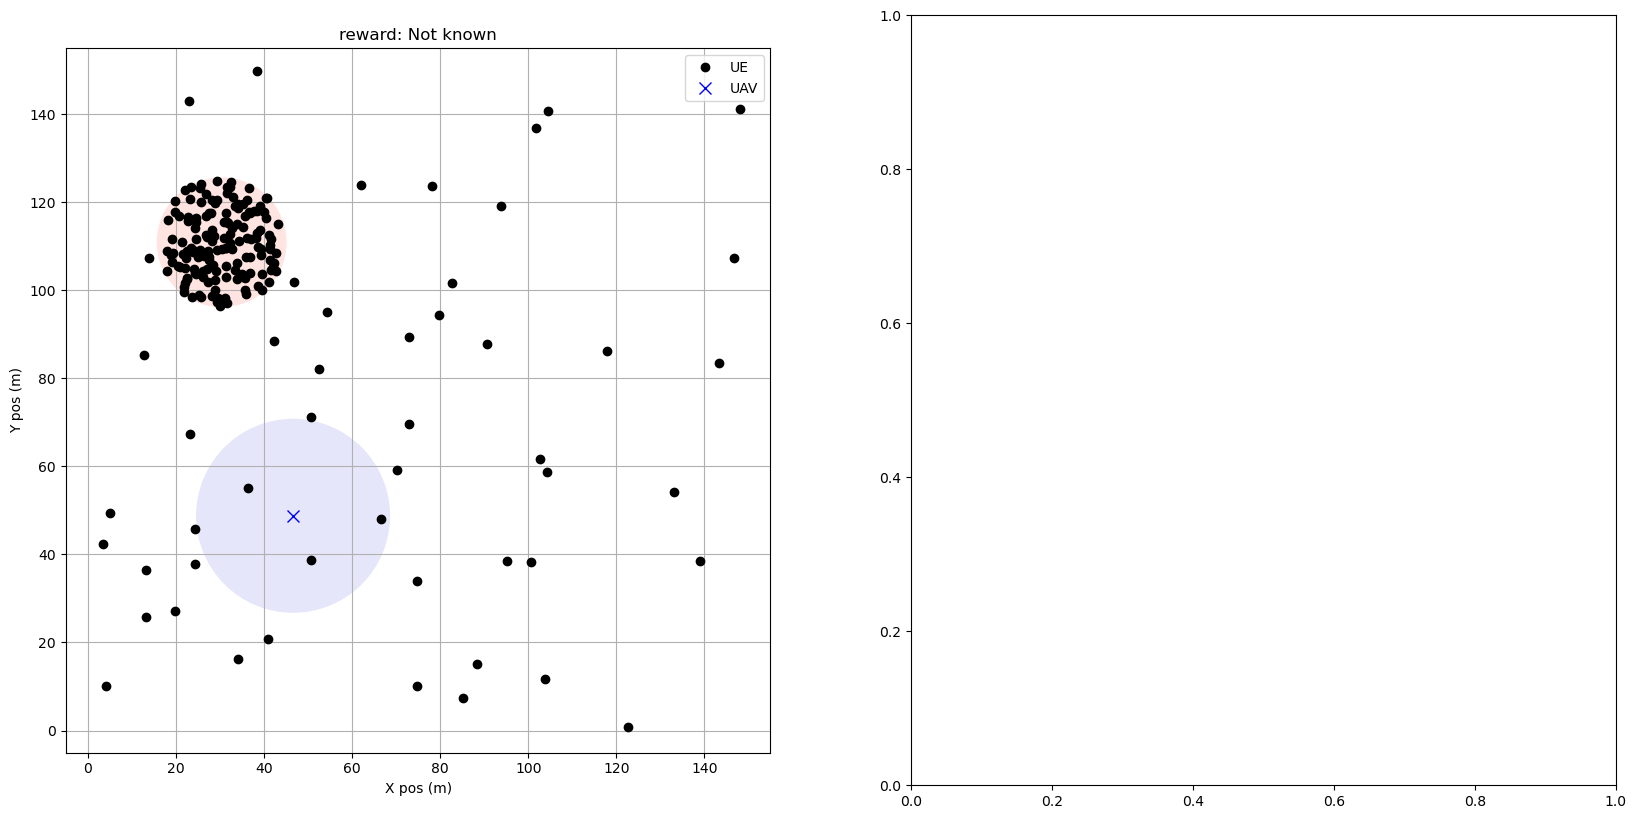

In [177]:
env.render()

In [178]:
env.get_count_of_UEs_covered()

3

In [179]:
state_dims = env.state_space[0].shape[0]
num_actions = env.action_space[0].n
print(f"Single Agent UAV env: State dimension: {state_dims}, Number of actions: {num_actions}")

Single Agent UAV env: State dimension: 2, Number of actions: 9


### Prepare the environment to work with PyTorch

In [180]:
state = env.reset()
action = [2 for i in range(env.UAV_count)] 
print(f"Sample state: {state}")
next_state, reward, done, _ = env.step(action)
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: [[105.81209504 121.27867526]]
Next state: [[110.05473328 125.52131653]], Reward: -100, Done: False


In [181]:
action_vector = np.array([torch.tensor(0) for _ in range(env.UAV_count)])
action_vector = np.array([action_vector[i].item() for i in range(env.UAV_count)])
print(type(action_vector))

<class 'numpy.ndarray'>


In [182]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        obs = self.env.reset()
        # print("obs: ", obs)
        return torch.from_numpy(obs).unsqueeze(dim=0).float()
    
    def step(self, action):
        # print("type of action inside wrapper: ", type(action))
        # action = action.item()
        next_state, reward, done, info = self.env.step(action)
        # print(next_state, reward, done)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [183]:
env = PreprocessEnv(env)

In [184]:
state = env.reset()
action_vector = np.array([torch.tensor(5) for _ in range(env.UAV_count)])
print(f"Sample state: {state[0]}")
next_state, reward, done, _ = env.step(action_vector)
print(f"Next state: {next_state[0]}, Reward: {reward}, Done: {done}")

Sample state: tensor([[73.2223, 81.1260]])
Next state: tensor([[67.2223, 81.1260]]), Reward: tensor([[-100.]]), Done: tensor([[False]])


## Create the Q-Network and policy

<br><br>

### Create the Q-Network: $\hat q(s,a| \theta)$

In [185]:
q_networks = [nn.Sequential(
    nn.Linear(state_dims, 64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, num_actions)   
) for i in range(env.UAV_count)]

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [186]:
target_q_networks = [copy.deepcopy(q_networks[i]).eval() for i in range(env.UAV_count)]

### Create the exploratory policy: $b(s)$

In [187]:
def policy(state, epsilon=0., UAV_index=0):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_networks[UAV_index](state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

## Create the Experience Replay buffer

In [188]:
class ReplayMemory:
    
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        # print("printing batch inside sample() function: ", batch)
        return_ls = []
        for items in batch:
            # print("printing items: ", items)
            # print("printing concatenation: ", torch.cat(items))
            return_ls.append(torch.cat(items))
        # print("printing given concat operation: ", [torch.cat(items) for items in batch])
        # return [torch.cat(items) for items in batch]
        return return_ls

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

## Implement the algorithm

</br></br>

In [189]:
current_dir = os.getcwd()
log_file_path_relative = "training_logs.txt"
if "results_and_logs" not in os.listdir(current_dir):
    os.mkdir("results_and_logs")
log_file_path_absolute = os.path.join(current_dir, "results_and_logs", log_file_path_relative)

In [190]:
def deep_q_learning(log_file, q_networks, policy, episodes, alpha = 0.001,
                    batch_size = 32, gamma = 0.99, epsilon = 0.2):
    optims = [AdamW(q_networks[i].parameters(), lr= alpha) for i in range(env.UAV_count)]
    memory = ReplayMemory()
    stats= {'MSE Loss': [], 'Average_Returns': []}
    log_file_obj = open(log_file, 'w')
    for episode in tqdm(range(1, episodes+1)):
        state = env.reset()
        # print("state after reset: ", state)
        # print("printing state type inside deep_q_learning() function: ", state)
        done = False
        ep_return = 0.
        log_file_obj.write("-----------------------------episode " + str(episode) + "-----------------------------\n")
        # print("-----------------------------episode ", episode, "-----------------------------")
        while not done:
            np_state = torch.flatten(state, end_dim=-2).numpy()
            # print("test print here: ", torch.flatten(state, end_dim=-2)[0])
            # print("policy output of 0th network: ", policy(torch.flatten(state, end_dim=-2)[0], epsilon, 0))
            action = torch.tensor([[[policy(torch.flatten(state, end_dim=-2)[i], epsilon, i)] for i in range(env.UAV_count)]])
            np_action = [act.item() for act in action[0]]
            # print("current state: ", state)
            # print("current action being taken: ", action)
            # print("numpy version of the action: ", np_action)
            # print("extra printing: ", action[0][0])
            # print("action inside deep_q_learning(): ", action)
            next_state, reward, done, _ = env.step(np_action)
            # print("UEs covered: ", env.get_count_of_UEs_covered())
            # print("next state: ", next_state)
            memory.insert([state, action, reward, done, next_state])
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                # action_b = torch.flatten(action_b, end_dim = -2)
                # print("UAV action tensor: ", action_b)
                # print("state sample 0th UAV: ", state_b[:, 0, :])
                # print("action sample 0th UAV: ", action_b[:, 0, :])
                # print("Entering gradient descent:-\n state: ", state_b[:, 0, :], "action: ", action_b[:, 0, :])
                loss_sum = 0
                for i in range(env.UAV_count):
                    # qsa_input_action = 
                    qsa_b = q_networks[i](state_b[:, i, :]).gather(1, action_b[:, i, :])
                    
                    next_qsa_b = target_q_networks[i](next_state_b[:, i, :])
                    next_qsa_b = torch.max(next_qsa_b, dim =-1, keepdim=True)[0]
                    
                    # print("printing inverse of done values: ", ~done_b)
                    target_b = reward_b + (~done_b) * gamma * next_qsa_b
                    # print("printing target: ", target_b)
                    # print("reward[0]: ", reward_b[1], "done: ", done_b[1], "gamma: ", gamma, "next_qsa_b: ", next_qsa_b[1])
                    loss = F.mse_loss(qsa_b, target_b)
                    q_networks[i].zero_grad()
                    loss.backward()
                    optims[i].step()
                    loss_sum += loss
                stats['MSE Loss'].append(loss_sum)
            
            state = next_state
            ep_return +=reward.item()
        log_file_obj.write("no. of UEs covered (Reward): " + str(reward.item()) + "\n")
        # print("no. of UEs covered (Reward): ", reward.item())
        stats['Average_Returns'].append(float(ep_return) / env.timesteps_in_episode)
    
        if episode % 10 ==0:
            for i in range(env.UAV_count):
                target_q_networks[i].load_state_dict(q_networks[i].state_dict())
    log_file_obj.close()
    return stats

In [191]:
stats = deep_q_learning(log_file_path_absolute, q_networks, policy, 3000)

 55%|█████▌    | 1650/3000 [03:40<03:00,  7.50it/s]


KeyboardInterrupt: 

In [192]:
def plot_stats1(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        
        for j in range(len(vals)):
            if(torch.is_tensor(vals[j])):
                vals[j] = vals[j].detach().numpy()
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


In [193]:
a = torch.tensor([[[ 43.848907, 101.006615]]])
torch.flatten(a, end_dim=-2)[0]

tensor([ 43.8489, 101.0066])

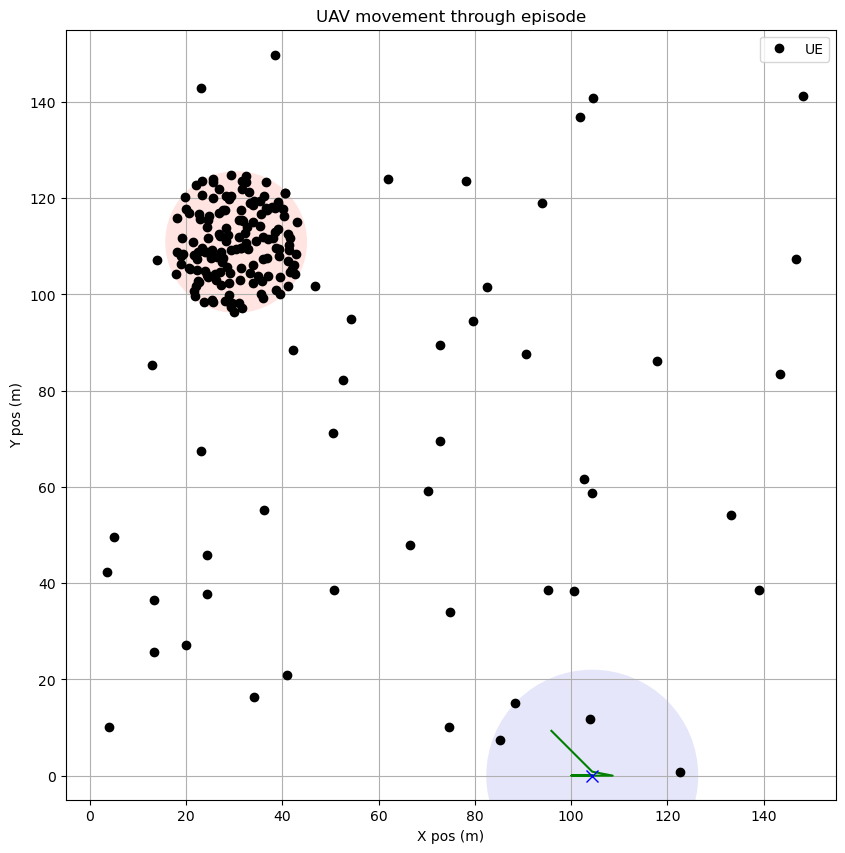

In [198]:
def run_random_episode():
  
  state = env.reset()
  # print("beginning state: ", state[0])
  done = False
  UAV_positions_list = [state.numpy()[0]]
  cnt=0
  while not done:
    # print(f"{cnt=}, {env.timesteps_in_episode=}")
    cnt+=1
    # print(state.numpy())
    action = torch.tensor([[[policy(state=torch.flatten(state, end_dim=-2)[i], epsilon=0., UAV_index=i)] for i in range(env.UAV_count)]])
    np_action = [act.item() for act in action[0]]
    # print(np_action)
    # action = policy(state, epsilon=0.)
    # print("action: ", action)
    new_state, reward, done, _ = env.step(np_action)
    # print(f"{done=}")
    # print("new_state: ", new_state[0][:2])
    state = new_state
    UAV_positions_list.append(state.numpy()[0])

  UAV_positions_list = np.array(UAV_positions_list)
  # print(UAV_positions_list)
  # print(UAV_positions_list[:, 0, 0])
  env.render_UAV_movement_through_episode(UAV_positions_list = UAV_positions_list)
  return

run_random_episode()

In [142]:
env.get_count_of_UEs_covered()

2

## Show results

### Plot execution stats

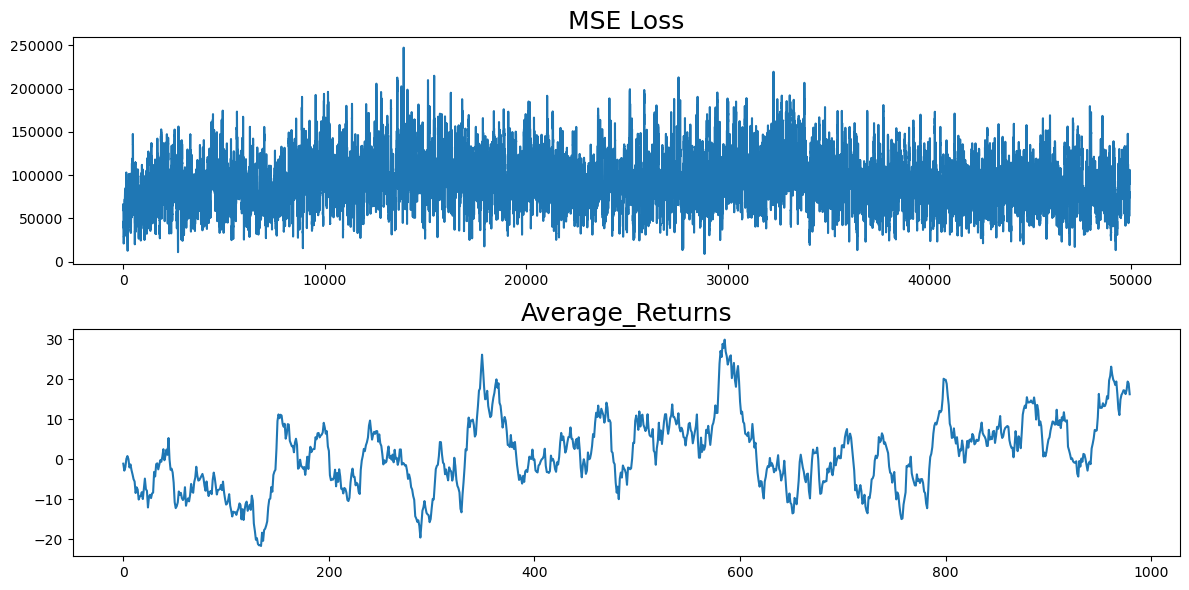

In [145]:
plot_stats1(stats)

### Test the resulting agent

In [ ]:
test_agent(env, policy, episodes=2)

NameError: ignored

In [ ]:
env.close()